## MHW Case Studies Figure

In [1]:
## LOAD IN OBSERVED AND MODELLED MHW STATISTICS
import xarray as xr
noaa_mhw_stats = xr.open_dataset('/g/data/e14/ts7341/Figure_Code_For_Manuscript/Science/mhws_NOAA.nc')
noaa_mhw_stats.load()
model_mhw_stats = xr.open_dataset('/g/data/e14/ts7341/Figure_Code_For_Manuscript/Science/full_MHW_data.nc')
model_mhw_stats.load()

<xarray.Dataset> Size: 475MB
Dimensions:          (lat: 171, lon: 1440, event: 24)
Coordinates:
  * lon              (lon) float64 12kB -279.9 -279.6 -279.4 ... 79.62 79.88
  * lat              (lat) float64 1kB -81.08 -80.97 -80.87 ... -63.17 -63.06
  * event            (event) int64 192B 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23
Data variables:
    index_start      (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    index_end        (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    date_start       (lat, lon, event) datetime64[ns] 47MB NaT NaT ... NaT NaT
    date_end         (lat, lon, event) datetime64[ns] 47MB NaT NaT ... NaT NaT
    duration         (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    n_event          (lat, lon) int64 2MB 0 0 0 0 0 0 0 0 0 ... 9 9 7 8 7 7 6 8
    index_peak       (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    date_peak        (lat, lon, event) datetime64[ns] 47MB NaT NaT ... NaT NaT
    intensity_max    (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    intensity_mean   (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    intensity_cumul  (lat, lon, event) float64 47MB nan nan nan ... nan nan nan

In [2]:
## LOAD IN SEA-ICE DATA FROM ACCESS-OM2
ice = xr.open_mfdataset(['/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1982_1988.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1989_1996.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_1997_2004.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2005_2011.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2012_2015.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2016-2022.nc',
                         '/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/ice_2023.nc'])
ice_new = xr.open_mfdataset('/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_data_2016_2024/hi_m_and_congel/*.nc')
ice_clim = xr.open_mfdataset('/g/data/e14/ts7341/Analysis_Using_Daily_JRA/ice_climatologies/*.nc')

## HAVE TO ASSIGN THE DAYS FROM THE SEA-ICE DATA TO THE CLIMATOLOGY
ice = ice.assign_coords(dayofyear=ice['time'].dt.dayofyear).sel(time = slice('1982','2023-12-29'))
ice_new = ice_new.assign_coords(dayofyear=ice_new['time'].dt.dayofyear).sel(time = slice('1982','2023-12-29'))

clim = ice_clim.sel(dayofyear=ice['dayofyear'])

clim_ice_access = ice_clim.aice.load()
ice_access = ice.aice.load()

In [3]:
##LOAD IN THE NOAA SEA-ICE DATA HERE 
import glob
import xarray as xr
import re

import xarray as xr

# Open only 2000–2023 files
sea_ice = xr.open_mfdataset(
    [
        f'/g/data/e14/ts7341/NOAA Data/NOAA OISST Sea Ice/icec.day.mean.{year}.nc'
        for year in range(1982, 2024)
    ],
    combine='by_coords',
    chunks={'time': 365}  # chunk by year to reduce memory usage
)

# Select Antarctic region (latitudes south of -55)
sea_ice = sea_ice.sel(lat=slice(-90, -55))

ice_clim = xr.open_dataset('/g/data/e14/ts7341/NOAA Data/NOAA OISST Sea Ice/ice_clim.nc')
ice_clim

# Assign dayofyear to c_ice
c_ice = sea_ice.assign_coords(dayofyear=sea_ice['time'].dt.dayofyear)

# Align climatology using dayofyear and assign dates from temp
climatology_ice = ice_clim.sel(dayofyear=c_ice['dayofyear'])
climatology_ice = climatology_ice.icec.assign_coords(time=c_ice['time'])

noaa_sea_ice = c_ice.icec
noaa_clim_sea_ice = climatology_ice

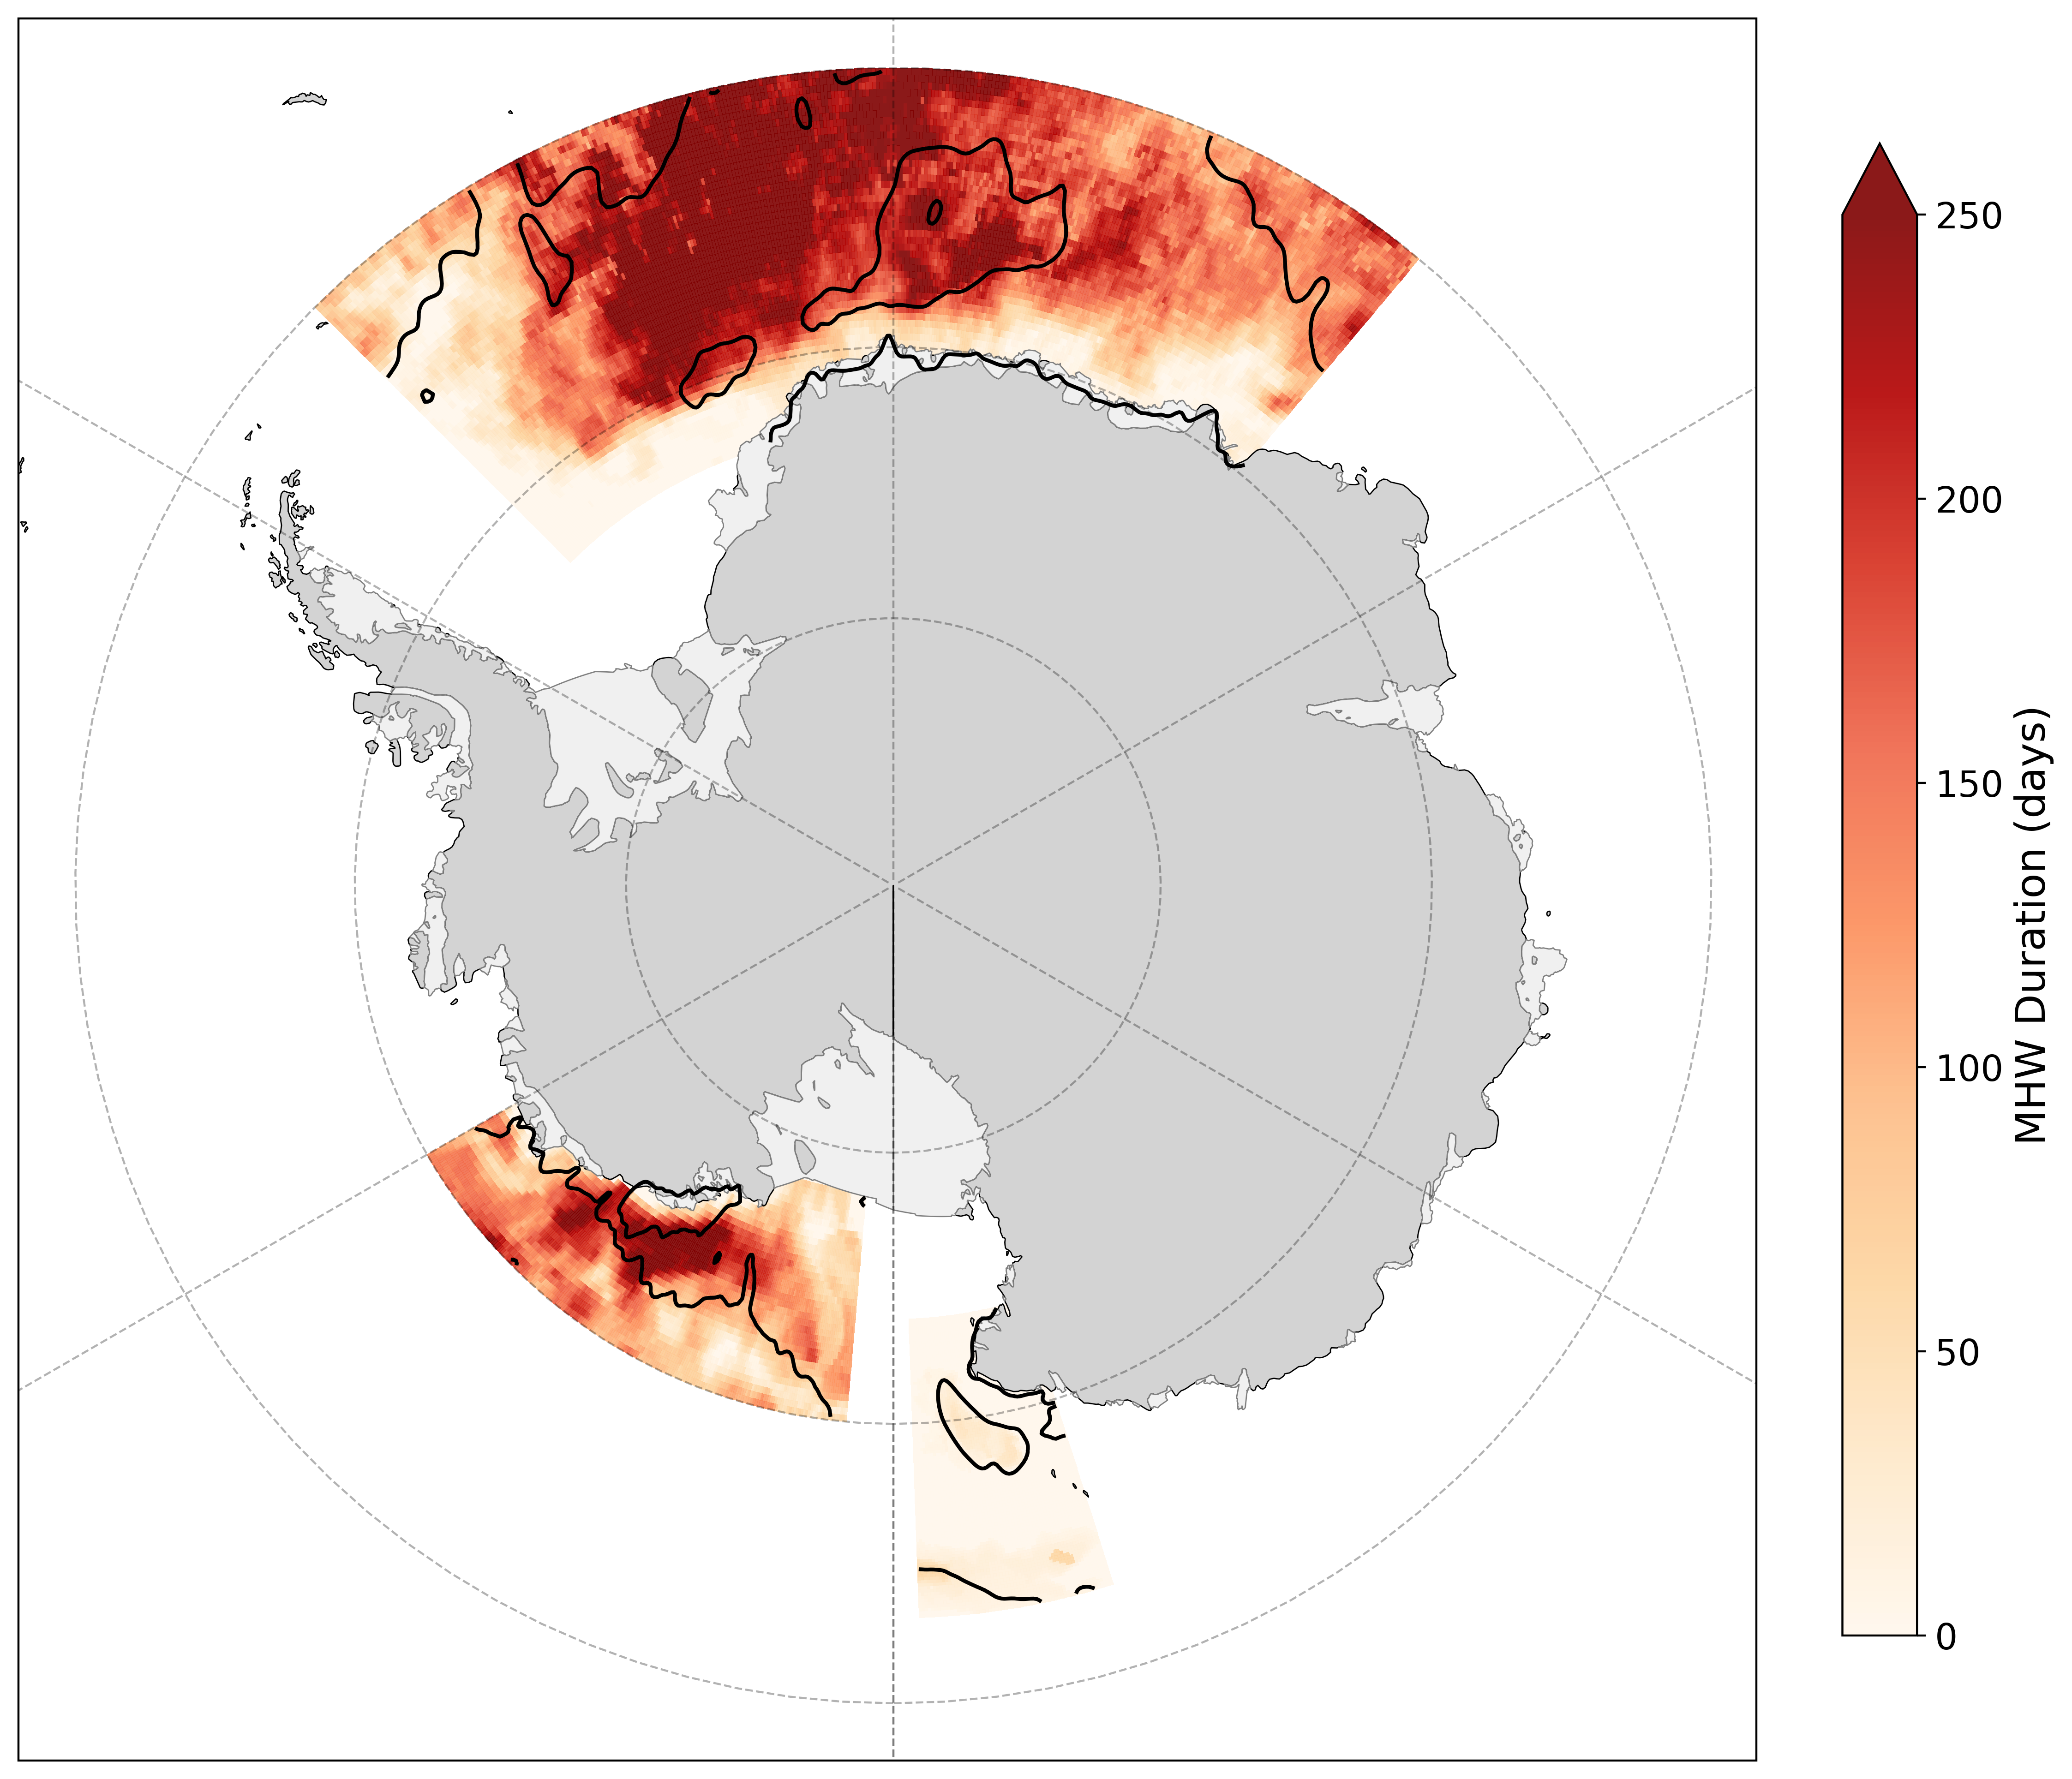

CPU times: user 25.4 s, sys: 2.62 s, total: 28.1 s
Wall time: 28.5 s


In [43]:
%%time
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.ndimage import gaussian_filter

## FIX THE COORDINATE SYSTEM OF THE DATA TO ENSURE IT IS UNIFORM FOR BOTH (NOAA GOES 0-360, ACCESS-OM2 GOES -280 TO 80)
def _to_lon180(ds, lon_name="lon"):
    if lon_name not in ds.coords:
        return ds
    lon = ds[lon_name]
    if float(lon.max()) > 180:
        lon180 = ((lon + 180) % 360) - 180
        ds = ds.assign_coords({lon_name: lon180})
        ds = ds.sortby(lon_name)
    return ds

## PICKING THE CASE STUDY MHW EVENTS THAT WE SELECTED IN THIS THESIS
def filter_event(ds, start, end, lon_bounds=None, lat_bounds=None):
    if ds is None:
        return ds
    start, end = pd.to_datetime(start), pd.to_datetime(end)
    ds2 = _to_lon180(ds.copy(), lon_name="lon")
    if lon_bounds:
        ds2 = ds2.sel(lon=slice(*lon_bounds))
    if lat_bounds:
        ds2 = ds2.sel(lat=slice(*lat_bounds))
    if ds2.lon.size == 0 or ds2.lat.size == 0:
        return ds2.sel(event=[])
    date_start = ds2["date_start"].min(dim=("lat", "lon"), skipna=True)
    date_end = ds2["date_end"].max(dim=("lat", "lon"), skipna=True)
    mask = (date_start <= np.datetime64(end)) & (date_end >= np.datetime64(start))
    selected_events = ds2["event"][mask.values]
    return ds2.sel(event=selected_events) if selected_events.size > 0 else ds2.sel(event=[])

def safe_sum(da, dim):
    if da is None or dim not in da.dims or da.sizes.get(dim, 0) == 0:
        return None
    return da.sum(dim=dim, skipna=True)

def select_by_bounds(da, lon_min, lon_max, lat_min, lat_max, lon_name="lon", lat_name="lat"):
    if da is None:
        return da
    da = _to_lon180(da, lon_name=lon_name)
    return da.sel({lon_name: slice(lon_min, lon_max), lat_name: slice(lat_min, lat_max)})

## Filter model
start, end = np.datetime64("2020-04-01"), np.datetime64("2020-10-31")
model_mask = (model_mhw_stats["date_start"] <= end) & (model_mhw_stats["date_end"] >= start)
model_filtered = model_mhw_stats.where(model_mask, drop=True).sel(lon=slice(-200, -182), lat=slice(-76, -63))

## ACCESS ice coordinates
ice_lon_coord = "xt_ocean" if "xt_ocean" in ice_access.dims else "lon"
ice_lat_coord = "yt_ocean" if "yt_ocean" in ice_access.dims else "lat"
ice_access_filtered = ice_access.sel({
    ice_lon_coord: slice(-200, -182),
    ice_lat_coord: slice(-76, -63)
})

# Events and sea-ice dictionary
events = {
    "2021–22 (Nov–May)": filter_event(noaa_mhw_stats, "2021-11-01", "2022-06-30",
                                      lon_bounds=(-175, -120), lat_bounds=(-79, -70)),
    "2016–17 (Nov–May)": filter_event(noaa_mhw_stats, "2016-11-01", "2017-04-30",
                                      lon_bounds=(-45, 40), lat_bounds=(-73, -60)),
    "2020 (May–Oct)": model_filtered
}
sea_ice_dict = {
    "2021–22 (Nov–May)": noaa_sea_ice,
    "2016–17 (Nov–May)": noaa_sea_ice,
    "2020 (May–Oct)": ice_access_filtered
}
sea_ice_date_spec = {
    "2021–22 (Nov–May)": (2022, 1),
    "2016–17 (Nov–May)": (2016, 12),
    "2020 (May–Oct)": (2020, 9)
}

## MHW colour scale
all_vals = [
    np.ravel(da.values)
    for ds in events.values()
    if ds is not None and "duration" in ds
    and (da := safe_sum(ds["duration"], "event")) is not None
    and da.size > 0
]
vmin = np.nanmin(np.concatenate(all_vals)) if all_vals else 0
vmax = 250
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

## Plotting routine
fig = plt.figure(figsize=(15, 15), dpi=400)
proj = ccrs.SouthPolarStereo()
ax = plt.axes(projection=proj)

## Background, land and ice shelves
ax.add_feature(cfeature.LAND.with_scale("50m"), facecolor='lightgray', edgecolor="black", linewidth=0.5, zorder=2)
ax.set_facecolor('white')
ice_shelves = cfeature.NaturalEarthFeature(category='physical', name='antarctic_ice_shelves_polys', scale='50m')
ax.add_feature(ice_shelves, facecolor='#f0f0f0', edgecolor='gray', linewidth=0.5, zorder=2)

mappable = None
for title, ds_event in events.items():
    da = safe_sum(ds_event["duration"], "event")
    if da is None or da.size == 0:
        continue
    ds_tmp = _to_lon180(ds_event)
    
    # MHW duration
    mappable = da.plot(
        x="lon", y="lat", transform=ccrs.PlateCarree(),
        cmap="OrRd", norm=norm, add_colorbar=False, ax=ax, alpha=0.9,
        extend='max', zorder=1
    )

    # Sea-ice data
    si_data = sea_ice_dict.get(title)
    if si_data is not None:
        lon_coord = "xt_ocean" if "xt_ocean" in si_data.dims else "lon"
        lat_coord = "yt_ocean" if "yt_ocean" in si_data.dims else "lat"
        year, month = sea_ice_date_spec[title]
        si = select_by_bounds(si_data,
                              float(ds_tmp.lon.min()), float(ds_tmp.lon.max()),
                              float(ds_tmp.lat.min()), float(ds_tmp.lat.max()),
                              lon_name=lon_coord, lat_name=lat_coord)
        if 'time' in si.dims and si.sizes['time'] > 0:
            si_avg = si.sel(time=(si['time'].dt.year == year) & (si['time'].dt.month == month)).mean(dim="time", skipna=True)
            if np.isfinite(si_avg).any():
                smoothed_si = gaussian_filter(si_avg.fillna(0).values, sigma=1.5)
                si_avg = xr.DataArray(smoothed_si, dims=si_avg.dims, coords=si_avg.coords)
                contour_level = [0.85] if title == "2020 (May–Oct)" else [0.3]
                si_avg.plot.contour(
                    x=lon_coord, y=lat_coord, ax=ax, transform=ccrs.PlateCarree(),
                    levels=contour_level, colors=['black'], linewidths=1.5, zorder=3
                )


## Map and grid
ax.set_extent([-180, 180, -90, -58], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.8, color='black', alpha=0.3, linestyle='--')
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 60))
gl.ylocator = plt.FixedLocator(np.arange(-80, -50, 10))
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.xlabel_style = {'size': 12, 'color': 'black', 'weight': 'bold'}
gl.ylabel_style = {'size': 12, 'color': 'black', 'weight': 'bold'}

## Colourbar
if mappable:
    cbar = plt.colorbar(mappable, ax=ax, orientation="vertical", pad=0.04, shrink=0.7, extend='max')
    cbar.set_label("MHW Duration (days)", fontsize=16)
    cbar.ax.tick_params(labelsize=14)

## Save figure
# plt.savefig('/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/southern_ocean_mhw.png',
#             dpi=800, bbox_inches='tight', pad_inches=0.1)
# plt.show()


# MHW Model Validation

In [2]:
import xarray as xr
noaa_mhw = xr.open_dataset('/g/data/e14/ts7341/Figure_Code_For_Manuscript/Science/mhws_NOAA.nc')
noaa_mhw.load()
access_mhw = xr.open_dataset('/g/data/e14/ts7341/Figure_Code_For_Manuscript/Science/full_MHW_data.nc')
access_mhw.load()

<xarray.Dataset> Size: 475MB
Dimensions:          (lat: 171, lon: 1440, event: 24)
Coordinates:
  * lon              (lon) float64 12kB -279.9 -279.6 -279.4 ... 79.62 79.88
  * lat              (lat) float64 1kB -81.08 -80.97 -80.87 ... -63.17 -63.06
  * event            (event) int64 192B 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23
Data variables:
    index_start      (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    index_end        (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    date_start       (lat, lon, event) datetime64[ns] 47MB NaT NaT ... NaT NaT
    date_end         (lat, lon, event) datetime64[ns] 47MB NaT NaT ... NaT NaT
    duration         (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    n_event          (lat, lon) int64 2MB 0 0 0 0 0 0 0 0 0 ... 9 9 7 8 7 7 6 8
    index_peak       (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    date_peak        (lat, lon, event) datetime64[ns] 47MB NaT NaT ... NaT NaT
    intensity_max    (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    intensity_mean   (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    intensity_cumul  (lat, lon, event) float64 47MB nan nan nan ... nan nan nan

In [18]:
noaa_mhw = noaa_mhw.sel(lat = slice(-90,-63))

In [17]:
access_mhw

<xarray.Dataset> Size: 475MB
Dimensions:          (lat: 171, lon: 1440, event: 24)
Coordinates:
  * lon              (lon) float64 12kB -279.9 -279.6 -279.4 ... 79.62 79.88
  * lat              (lat) float64 1kB -81.08 -80.97 -80.87 ... -63.17 -63.06
  * event            (event) int64 192B 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23
Data variables:
    index_start      (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    index_end        (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    date_start       (lat, lon, event) datetime64[ns] 47MB NaT NaT ... NaT NaT
    date_end         (lat, lon, event) datetime64[ns] 47MB NaT NaT ... NaT NaT
    duration         (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    n_event          (lat, lon) int64 2MB 0 0 0 0 0 0 0 0 0 ... 9 9 7 8 7 7 6 8
    index_peak       (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    date_peak        (lat, lon, event) datetime64[ns] 47MB NaT NaT ... NaT NaT
    intensity_max    (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    intensity_mean   (lat, lon, event) float64 47MB nan nan nan ... nan nan nan
    intensity_cumul  (lat, lon, event) float64 47MB nan nan nan ... nan nan nan

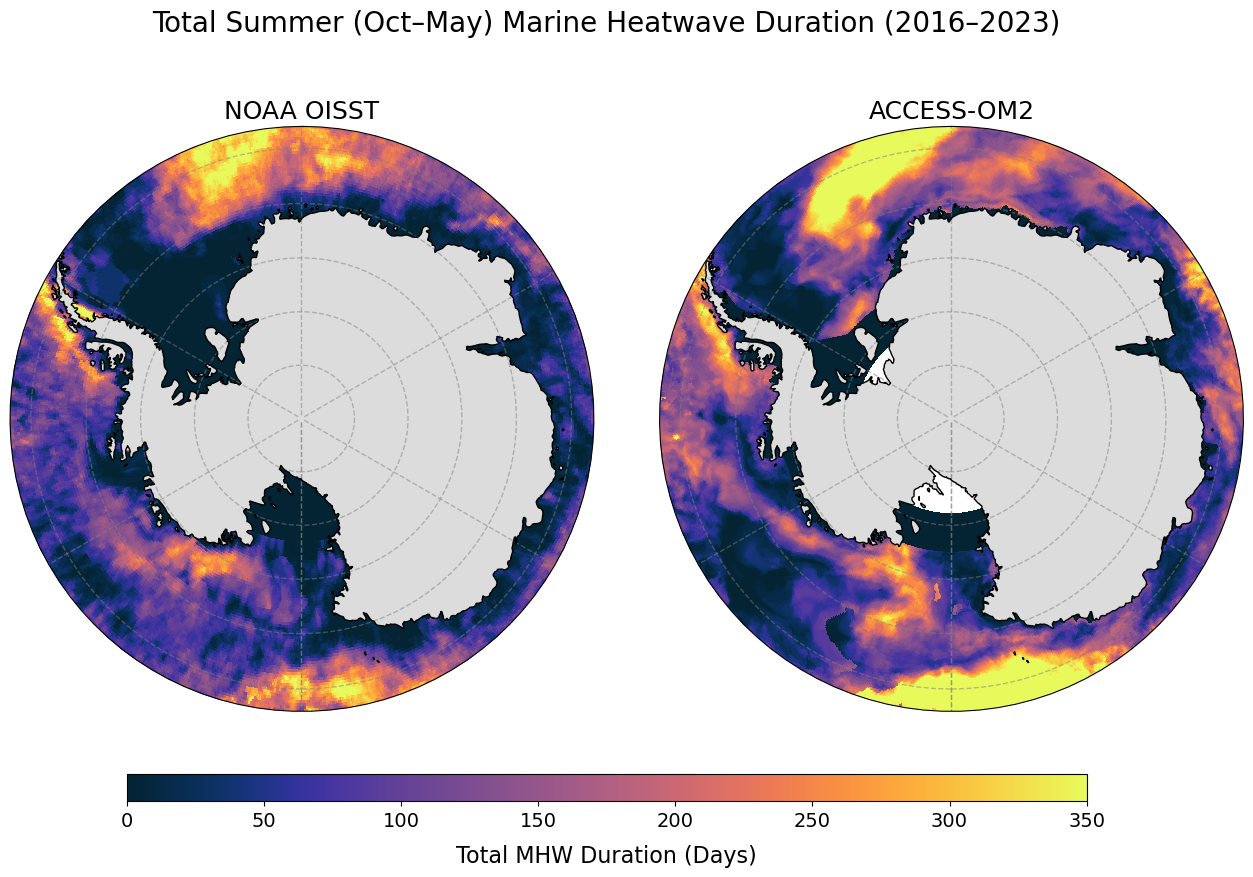

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

## 'SUMMER' months – primarily months where sea-ice concentration is low
summer_months = [10, 11, 12, 1, 2, 3, 4, 5]
def summer_duration(ds):
    months = ds["date_start"].dt.month
    mask = months.isin(summer_months)
    return ds["duration"].where(mask).sum(dim="event")

## Filter datasets accordingly
dur1_summer = summer_duration(noaa_mhw)
dur2_summer = summer_duration(access_mhw)

## Stylistic choices consistent with the rest of my figures
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 20
})

## Create my figures
fig, axes = plt.subplots(
    1, 2, 
    figsize=(16, 9), # Slightly adjusted figsize for better aspect ratio
    subplot_kw={'projection': ccrs.SouthPolarStereo()},
)

## Map projection and extent
crs = ccrs.PlateCarree()
extent = [-180, 180, -90, -63]

vmax = 350 ## Colourbar that I used visual inspection for, adjust the maximum value as you need

plots = [
    (dur1_summer, "NOAA OISST"),
    (dur2_summer, "ACCESS-OM2"),
]

## Plotting
for ax, (data, title) in zip(axes, plots):
    ax.set_extent(extent, crs)
    
    ax.add_feature(cfeature.LAND, facecolor="gainsboro", zorder=2)
    ax.coastlines(zorder=3, linewidth=1.0)
    
    p = data.plot.pcolormesh(
        ax=ax,
        transform=crs,
        cmap=cmocean.cm.thermal,
        vmax=vmax,
        vmin=0,
        add_colorbar=False
    )
    
    ax.gridlines(linewidth=1, color='gray', alpha=0.5, linestyle='--')
    
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = plt.matplotlib.path.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.set_title(title)

fig.subplots_adjust(bottom=0.2, top=0.85, wspace=0.1)

cbar_ax = fig.add_axes([0.2, 0.1, 0.6, 0.03]) 

cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Total MHW Duration (Days)', labelpad=10)
cbar.ax.tick_params(labelsize=14)

plt.suptitle("Total Summer (Oct–May) Marine Heatwave Duration (2016–2023)", fontsize=20)

# plt.savefig("/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/MHW_duration_comparison_publishable_bottom_cbar.png", dpi=400, bbox_inches='tight')
# plt.show()

## Example MHW Trends in the Ross

In [5]:
import xarray as xr
noaa_mhw = xr.open_dataset('/scratch/e14/ts7341/SEANOE/MHW_Statistics_Mask/full_MHW_data_1982_2024_RS_NOAA.nc')
noaa_mhw.load()
access_mhw = xr.open_dataset('/scratch/e14/ts7341/SEANOE/MHW_Statistics_Mask/full_MHW_data_1982_2024_RS.nc')
access_mhw.load()

<xarray.Dataset> Size: 85MB
Dimensions:          (lat: 66, lon: 320, event: 50)
Coordinates:
  * lon              (lon) float64 3kB -209.9 -209.6 -209.4 ... -130.4 -130.1
  * lat              (lat) float64 528B -76.96 -76.85 -76.75 ... -70.2 -70.09
  * event            (event) int64 400B 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
Data variables:
    index_start      (lat, lon, event) float64 8MB nan nan nan ... nan nan nan
    index_end        (lat, lon, event) float64 8MB nan nan nan ... nan nan nan
    date_start       (lat, lon, event) datetime64[ns] 8MB NaT NaT ... NaT NaT
    date_end         (lat, lon, event) datetime64[ns] 8MB NaT NaT ... NaT NaT
    duration         (lat, lon, event) float64 8MB nan nan nan ... nan nan nan
    n_event          (lat, lon) int64 169kB 0 0 0 0 0 0 0 ... 16 15 15 15 15 15
    index_peak       (lat, lon, event) float64 8MB nan nan nan ... nan nan nan
    date_peak        (lat, lon, event) datetime64[ns] 8MB NaT NaT ... NaT NaT
    intensity_max    (lat, lon, event) float64 8MB nan nan nan ... nan nan nan
    intensity_mean   (lat, lon, event) float64 8MB nan nan nan ... nan nan nan
    intensity_cumul  (lat, lon, event) float64 8MB nan nan nan ... nan nan nan

In [15]:
print(noaa_mhw)
print(access_mhw)

<xarray.Dataset> Size: 141MB
Dimensions:          (lat: 24, lon: 320, event: 229)
Coordinates:
  * lat              (lat) float32 96B -76.88 -76.62 -76.38 ... -71.38 -71.12
  * lon              (lon) float32 1kB 150.1 150.4 150.6 ... 229.4 229.6 229.9
  * event            (event) int64 2kB 0 1 2 3 4 5 6 ... 223 224 225 226 227 228
Data variables:
    index_start      (lat, lon, event) float64 14MB nan nan nan ... nan nan nan
    index_end        (lat, lon, event) float64 14MB nan nan nan ... nan nan nan
    date_start       (lat, lon, event) datetime64[ns] 14MB NaT NaT ... NaT NaT
    date_end         (lat, lon, event) datetime64[ns] 14MB NaT NaT ... NaT NaT
    duration         (lat, lon, event) float64 14MB nan nan nan ... nan nan nan
    n_event          (lat, lon) int64 61kB 0 0 0 0 0 0 0 ... 89 85 78 73 74 77
    index_peak       (lat, lon, event) float64 14MB nan nan nan ... nan nan nan
    date_peak        (lat, lon, event) datetime64[ns] 14MB NaT NaT ... NaT NaT
    intensity_m

Preprocessing NOAA MHW data...
Preprocessing ACCESS MHW data...

Calculating trends for NOAA OISST...
  - Processing 5643 spatial points with MHW events.
  - Calculating linear trends...

Calculating trends for ACCESS-OM2...
  - Processing 15828 spatial points with MHW events.
  - Calculating linear trends...

Plotting results...


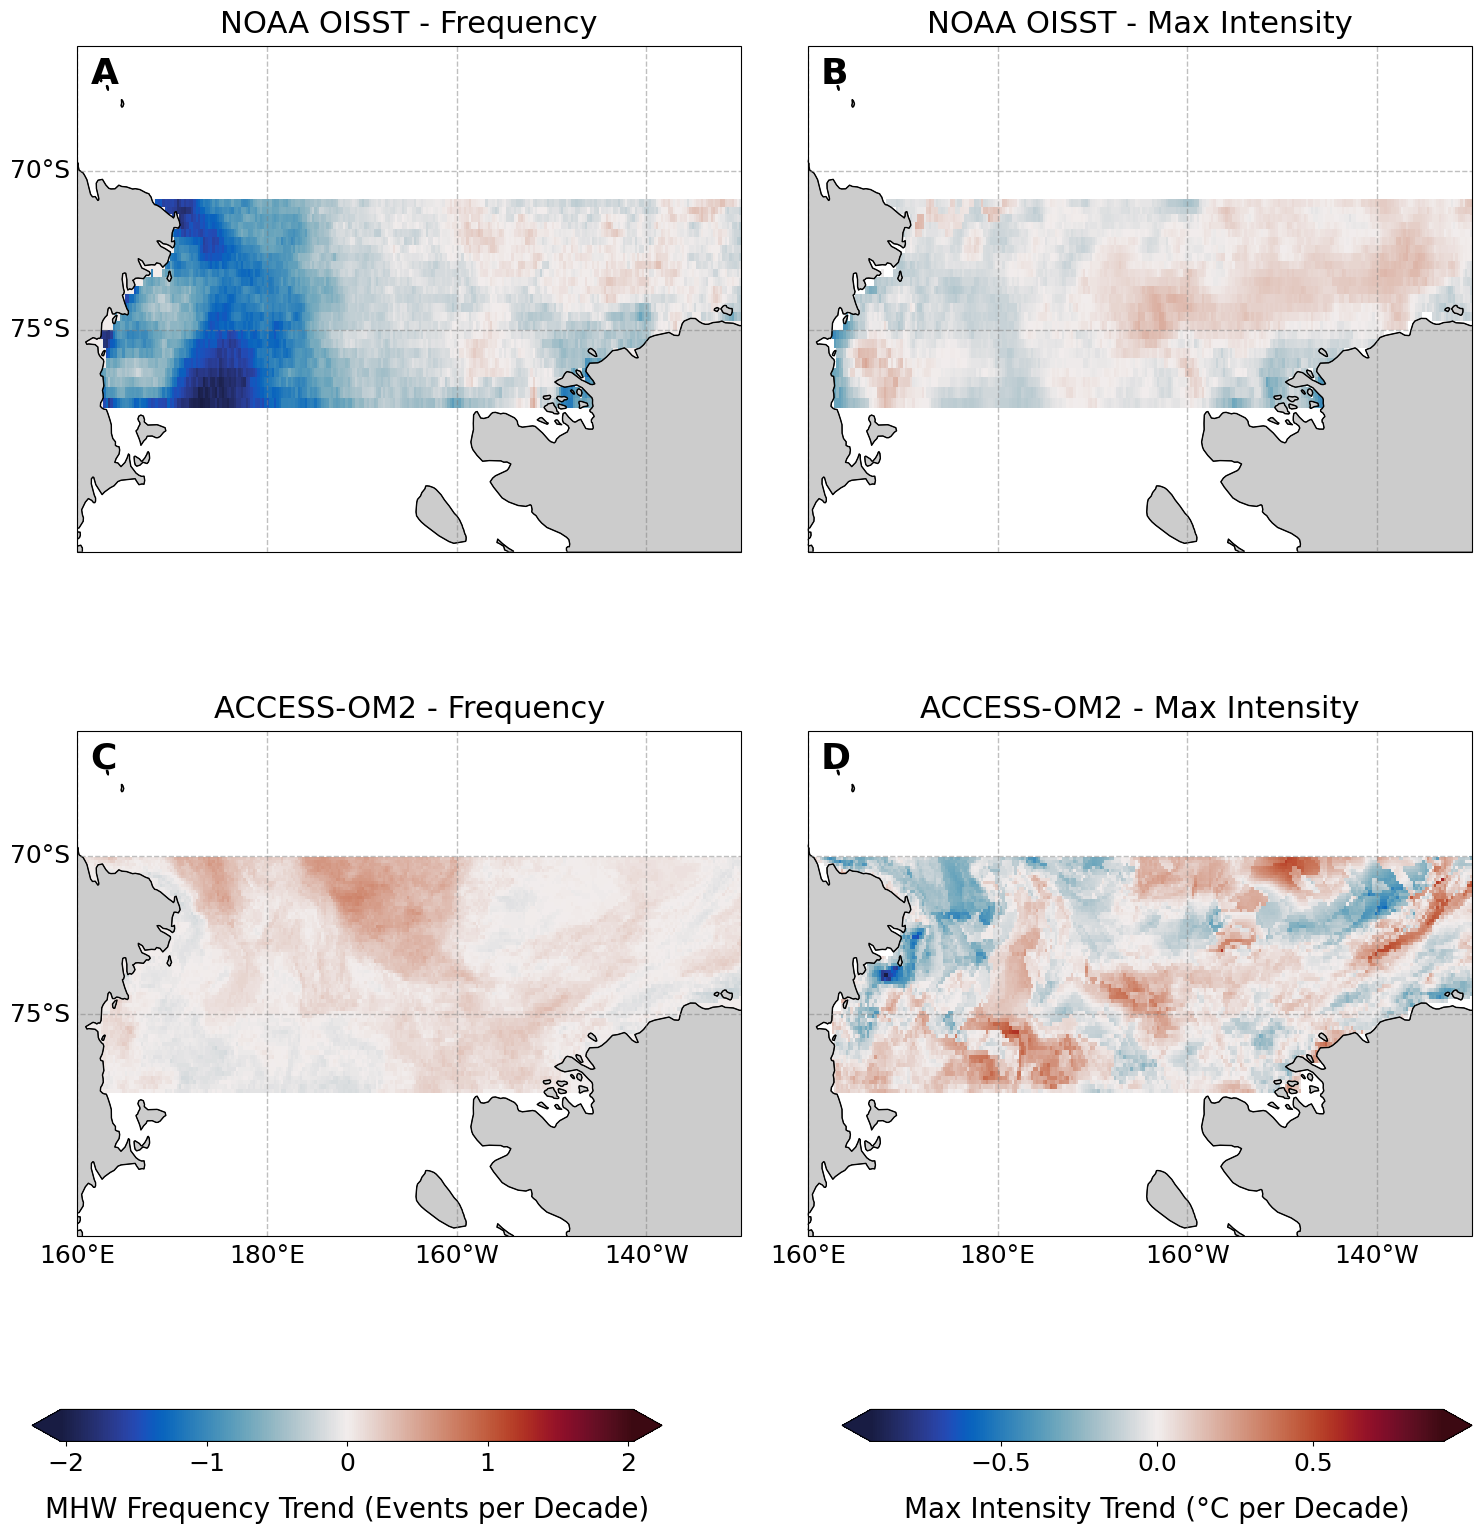

In [16]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean


def preprocess_mhw_data(ds):
    """
    Standardizes longitude to -180 to 180 and sorts coordinates. This is 
    particularly important here because of the annoying wrapping around 
    issue at the 180 line in the Ross Sea.
    """
    # Convert longitude from any range (e.g., 0-360) to -180 to 180
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    
    ds = ds.sortby('lon')
    ds = ds.sortby('lat')
    return ds

noaa_mhw = preprocess_mhw_data(noaa_mhw)
access_mhw = preprocess_mhw_data(access_mhw)
# ======================================================================


# ======================================================================
# --- 3. Trend Calculation Function ---
# Encapsulating the logic we developed into a reusable function.

def calculate_mhw_trends(mhw_ds):
    """
    Calculates decadal trends for MHW frequency and max intensity.
    """
    # Stack spatial dimensions
    stacked = mhw_ds.stack(space=('lat', 'lon'))

    # Pre-filter to remove spatial points with NO events
    valid_space_mask = stacked.date_start.notnull().any(dim='event')
    stacked_with_events_only = stacked.sel(space=valid_space_mask)

    # Drop empty event slots to make the dataset tidy
    valid_events = stacked_with_events_only.dropna(dim='event', how='all', subset=['date_start'])
    print(f"  - Processing {valid_events.space.size} spatial points with MHW events.")

    # Add a 'year' variable for easier grouping
    valid_events['year'] = valid_events.date_start.dt.year

    # --- Frequency Calculation ---
    def count_events_by_year(ds_group):
        group_simplified = ds_group.reset_index('space')
        return group_simplified.date_start.groupby(group_simplified.year).count()

    annual_frequency_stacked = valid_events.groupby('space', squeeze=False).apply(count_events_by_year)
    annual_frequency = annual_frequency_stacked.unstack('space').fillna(0)

    # --- Intensity Calculation ---
    def max_intensity_by_year(ds_group):
        group_simplified = ds_group.reset_index('space')
        return group_simplified.intensity_max.groupby(group_simplified.year).max()
        
    annual_max_intensity_stacked = valid_events.groupby('space', squeeze=False).apply(max_intensity_by_year)
    annual_max_intensity = annual_max_intensity_stacked.unstack('space')

    # Reindex to full time and space grid
    all_years = np.arange(int(mhw_ds.date_start.dt.year.min(skipna=True)), int(mhw_ds.date_start.dt.year.max(skipna=True)) + 1)
    annual_frequency = annual_frequency.reindex(year=all_years, lat=mhw_ds.lat, lon=mhw_ds.lon, fill_value=0)
    annual_max_intensity = annual_max_intensity.reindex(year=all_years, lat=mhw_ds.lat, lon=mhw_ds.lon, fill_value=np.nan)

    # --- Trend Calculation ---
    print("  - Calculating linear trends...")
    freq_coeffs = annual_frequency.polyfit(dim='year', deg=1, skipna=True)
    freq_trend = freq_coeffs.polyfit_coefficients.sel(degree=1) * 10 

    intensity_coeffs = annual_max_intensity.polyfit(dim='year', deg=1, skipna=True)
    intensity_trend = intensity_coeffs.polyfit_coefficients.sel(degree=1) * 10
    
    return freq_trend, intensity_trend

# Calculate trends for both datasets
print("\nCalculating trends for NOAA OISST...")
noaa_freq_trend_per_decade, noaa_intensity_trend_per_decade = calculate_mhw_trends(noaa_mhw)

print("\nCalculating trends for ACCESS-OM2...")
access_freq_trend_per_decade, access_intensity_trend_per_decade = calculate_mhw_trends(access_mhw)
# ======================================================================

# ======================================================================
# --- 4. Plotting ---
print("\nPlotting results...")

# Plotting Parameters
extent = [-200, -130, -80, -65] 
grid_label_size = 18; panel_title_size = 22; colorbar_label_size = 20
vmax_freq = max(abs(noaa_freq_trend_per_decade).max(), abs(access_freq_trend_per_decade).max())
vmax_intensity = max(abs(noaa_intensity_trend_per_decade).max(), abs(access_intensity_trend_per_decade).max())

plt.rcParams.update({'font.size': 14, 'axes.titlesize': panel_title_size, 'axes.labelsize': 16, 'xtick.labelsize': grid_label_size, 'ytick.labelsize': grid_label_size, 'legend.fontsize': 14})

fig, axes = plt.subplots(2, 2, figsize=(18, 16), subplot_kw={'projection': ccrs.Mercator(central_longitude=-180)})
axes = axes.flatten()

plots_data = [
    (noaa_freq_trend_per_decade, "NOAA OISST - Frequency", "Events per Decade", vmax_freq, 'A'),
    (noaa_intensity_trend_per_decade, "NOAA OISST - Max Intensity", "°C per Decade", vmax_intensity, 'B'),
    (access_freq_trend_per_decade, "ACCESS-OM2 - Frequency", "Events per Decade", vmax_freq, 'C'),
    (access_intensity_trend_per_decade, "ACCESS-OM2 - Max Intensity", "°C per Decade", vmax_intensity, 'D'),
]
plot_handles = []

for i, ax in enumerate(axes):
    data, title, cbar_label, vmax, label = plots_data[i]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="0.8", linewidth=0.5))
    ax.coastlines(resolution="50m")

    p = data.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=-vmax, vmax=vmax, add_colorbar=False)
    plot_handles.append(p)
    
    ax.text(0.02, 0.98, label, transform=ax.transAxes, fontsize=panel_title_size + 4, weight='bold', va='top')
    ax.set_title(title, fontsize=panel_title_size, pad=10)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--', zorder=1)
    gl.xlocator = mticker.FixedLocator([160, 180, -160, -140]); gl.ylocator = mticker.FixedLocator([-80, -75, -70, -65])
    gl.top_labels = False; gl.right_labels = False
    gl.left_labels = (i % 2 == 0); gl.bottom_labels = (i >= 2)
    gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': grid_label_size}; gl.ylabel_style = {'size': grid_label_size}

fig.subplots_adjust(bottom=0.15, top=0.95, wspace=0.1, hspace=0.15)

cbar_ax_freq = fig.add_axes([0.1, 0.05, 0.35, 0.02]) 
cbar_freq = fig.colorbar(plot_handles[0], cax=cbar_ax_freq, orientation='horizontal', extend='both')
cbar_freq.set_label('MHW Frequency Trend (Events per Decade)', fontsize=colorbar_label_size, labelpad=15)
cbar_freq.ax.tick_params(labelsize=grid_label_size)

cbar_ax_int = fig.add_axes([0.55, 0.05, 0.35, 0.02]) 
cbar_int = fig.colorbar(plot_handles[1], cax=cbar_ax_int, orientation='horizontal', extend='both')
cbar_int.set_label('Max Intensity Trend (°C per Decade)', fontsize=colorbar_label_size, labelpad=15)
cbar_int.ax.tick_params(labelsize=grid_label_size)

# plt.savefig("MHW_Trend_Comparison_Stats.png", dpi=400, bbox_inches='tight')
plt.show()

Preprocessing NOAA MHW data...
Preprocessing ACCESS MHW data...

Calculating max intensity trend for NOAA OISST...
  - Processing 5643 spatial points with MHW events.
  - Calculating linear trend for max intensity...

Calculating max intensity trend for ACCESS-OM2...
  - Processing 15828 spatial points with MHW events.
  - Calculating linear trend for max intensity...

Plotting results...


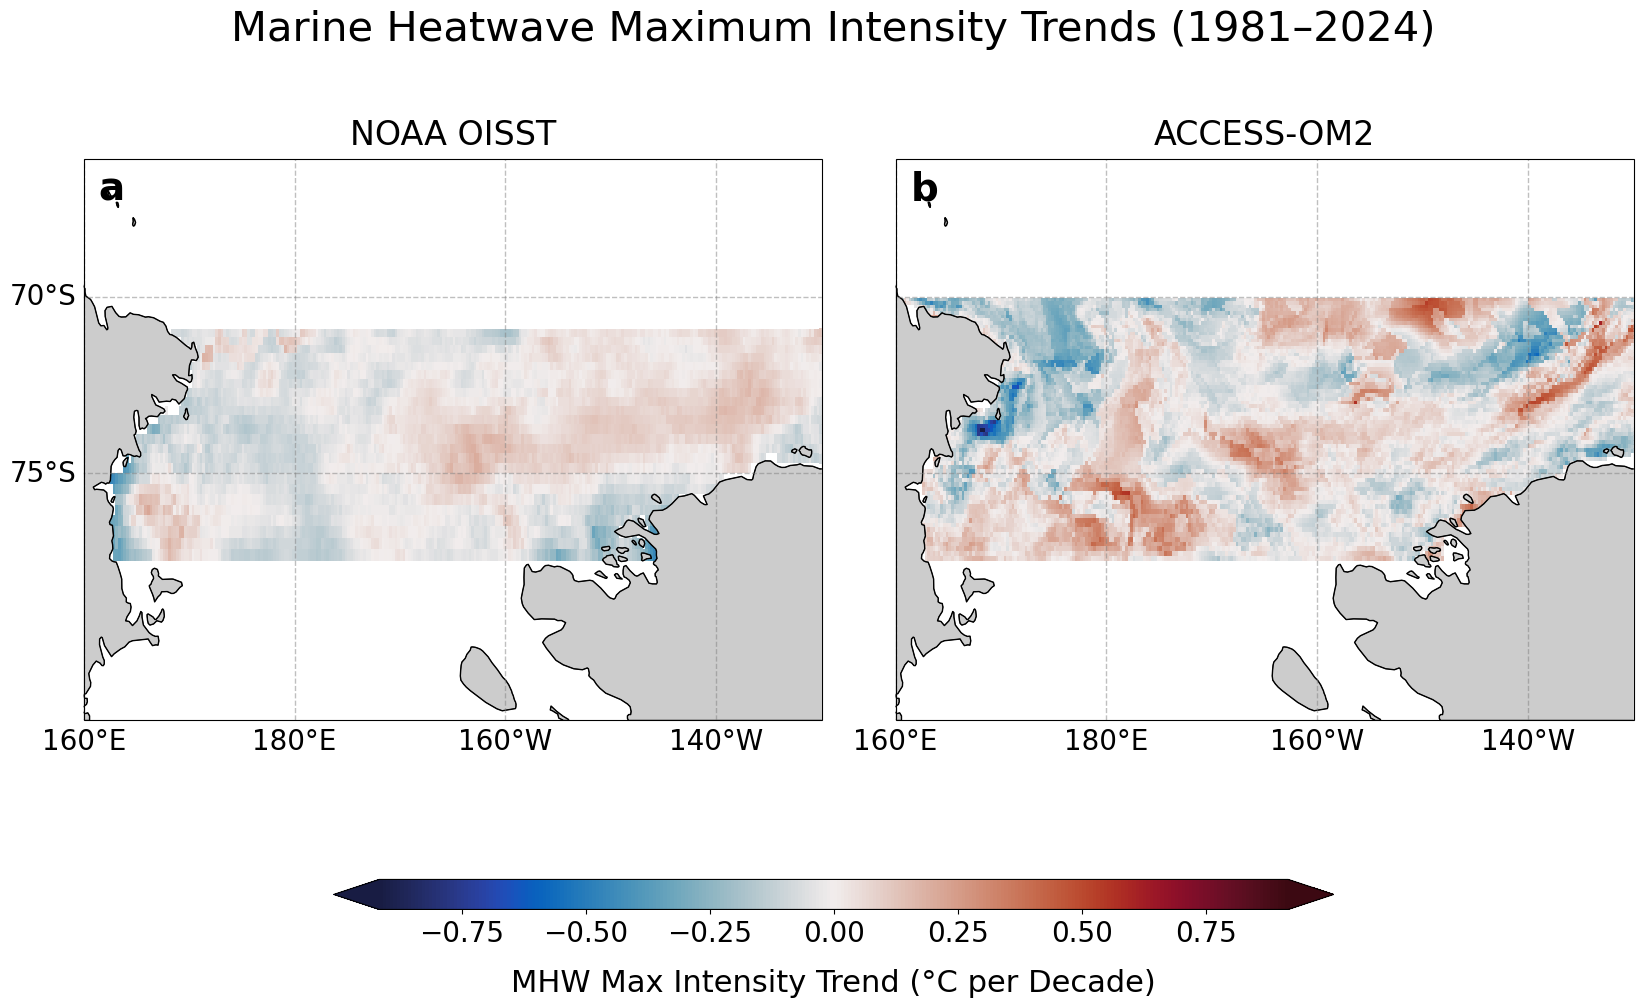

In [20]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

# ======================================================================
# --- 1. Load your actual data ---
# noaa_mhw = xr.open_dataset(...)
# access_mhw = xr.open_dataset(...)
# ======================================================================

# ======================================================================
# --- 2. PREPROCESSING: Fix and Standardize Coordinates ---

def preprocess_mhw_data(ds):
    """
    Standardizes longitude to -180 to 180 and sorts coordinates.
    """
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds = ds.sortby('lon').sortby('lat')
    return ds

print("Preprocessing NOAA MHW data...")
noaa_mhw = preprocess_mhw_data(noaa_mhw)
print("Preprocessing ACCESS MHW data...")
access_mhw = preprocess_mhw_data(access_mhw)
# ======================================================================


# ======================================================================
# --- 3. Trend Calculation Function (Simplified for Max Intensity Only) ---

def calculate_max_intensity_trend(mhw_ds):
    """
    Calculates the decadal trend for MHW max intensity.
    """
    # Stack spatial dimensions
    stacked = mhw_ds.stack(space=('lat', 'lon'))
    valid_space_mask = stacked.date_start.notnull().any(dim='event')
    stacked_with_events_only = stacked.sel(space=valid_space_mask)
    valid_events = stacked_with_events_only.dropna(dim='event', how='all', subset=['date_start'])
    print(f"  - Processing {valid_events.space.size} spatial points with MHW events.")

    valid_events['year'] = valid_events.date_start.dt.year

    # --- Max Intensity Calculation ---
    def max_intensity_by_year(ds_group):
        group_simplified = ds_group.reset_index('space')
        return group_simplified.intensity_max.groupby(group_simplified.year).max()
        
    annual_max_intensity_stacked = valid_events.groupby('space', squeeze=False).apply(max_intensity_by_year)
    annual_max_intensity = annual_max_intensity_stacked.unstack('space')

    # Reindex to full time and space grid
    all_years = np.arange(int(mhw_ds.date_start.dt.year.min(skipna=True)), int(mhw_ds.date_start.dt.year.max(skipna=True)) + 1)
    annual_max_intensity = annual_max_intensity.reindex(year=all_years, lat=mhw_ds.lat, lon=mhw_ds.lon, fill_value=np.nan)

    # --- Trend Calculation ---
    print("  - Calculating linear trend for max intensity...")
    max_intensity_coeffs = annual_max_intensity.polyfit(dim='year', deg=1, skipna=True)
    max_intensity_trend = max_intensity_coeffs.polyfit_coefficients.sel(degree=1) * 10
    
    return max_intensity_trend

# Calculate trends for both datasets
print("\nCalculating max intensity trend for NOAA OISST...")
noaa_max_intensity_trend = calculate_max_intensity_trend(noaa_mhw)

print("\nCalculating max intensity trend for ACCESS-OM2...")
access_max_intensity_trend = calculate_max_intensity_trend(access_mhw)
# ======================================================================

# ======================================================================
# --- 4. Plotting (1 row x 2 columns) ---
print("\nPlotting results...")

# Plotting Parameters
extent = [-200, -130, -80, -65] 
grid_label_size = 20; panel_title_size = 24; colorbar_label_size = 22

# Determine a single, shared color scale for both plots
vmax = np.nanmax([abs(noaa_max_intensity_trend).max(), abs(access_max_intensity_trend).max()])

plt.rcParams.update({'font.size': 16, 'axes.titlesize': panel_title_size, 'axes.labelsize': 18, 'xtick.labelsize': grid_label_size, 'ytick.labelsize': grid_label_size})

# Create a 1x2 figure
fig, axes = plt.subplots(
    1, 2, 
    figsize=(20, 10), 
    subplot_kw={'projection': ccrs.Mercator(central_longitude=-180)}
)
axes = axes.flatten()

# Plot data for the two panels
plots_data = [
    (noaa_max_intensity_trend, "NOAA OISST", 'a'),
    (access_max_intensity_trend, "ACCESS-OM2", 'b'),
]

for i, ax in enumerate(axes):
    data, title, label = plots_data[i]
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature("physical", "land", "50m", edgecolor="black", facecolor="0.8", linewidth=0.5))
    ax.coastlines(resolution="50m")

    # All plots use the same shared color scale (vmax)
    p = data.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap=cmocean.cm.balance, vmin=-vmax, vmax=vmax, add_colorbar=False)
    
    ax.text(0.02, 0.98, label, transform=ax.transAxes, fontsize=panel_title_size + 4, weight='bold', va='top')
    ax.set_title(title, fontsize=panel_title_size, pad=10)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--', zorder=1)
    gl.xlocator = mticker.FixedLocator([160, 180, -160, -140]); gl.ylocator = mticker.FixedLocator([-80, -75, -70, -65])
    gl.top_labels = False; gl.right_labels = False
    
    # Update label logic for 1x2 grid
    gl.left_labels = (i == 0) # Only the first plot
    gl.bottom_labels = True   # Both plots are on the bottom row
    
    gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': grid_label_size}; gl.ylabel_style = {'size': grid_label_size}

# --- Shared Colorbar for ALL panels ---
fig.subplots_adjust(bottom=0.2, top=0.9, wspace=0.1, hspace=0.1)
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.03]) 
cbar = fig.colorbar(p, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('MHW Max Intensity Trend (°C per Decade)', fontsize=colorbar_label_size, labelpad=15)
cbar.ax.tick_params(labelsize=grid_label_size)

# Add a main title for the whole figure
start_year = int(noaa_mhw.date_start.dt.year.min())
end_year = int(noaa_mhw.date_start.dt.year.max())
fig.suptitle(f"Marine Heatwave Maximum Intensity Trends ({start_year}–{end_year})", fontsize=30, y=0.98)

plt.savefig("/g/data/e14/ts7341/Figure_Code_For_Manuscript/Figures_Images/MHW_Max_Intensity_Trend_Comparison.png", dpi=400, bbox_inches='tight')
plt.show()